### 1 Loading Dataset

In [1]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive/Project/model1and2/')

Mounted at /content/drive


In [ ]:
!/opt/bin/nvidia-smi

Mon Jan 24 11:29:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from my_datasets import MyDataset
from my_models import MyModel
from data.delta_all_degree import delta_data_degree
from data.delta_all import delta_data
# [delta_x, delta_y, delta_theta, v_ref, v_ego, throttle, str_angle]

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [6]:
def split_dataset(data, split_list):
    #print(data.shape)
    split_num = data.shape[0] * np.array(split_list)
    #print(split_num)
    return data[:round(split_num[0]), :], data[round(split_num[0]):round(split_num[1]+split_num[0]), :], data[round(split_num[1]+split_num[0]):, :]
 
np.random.shuffle(delta_data) 
split_list = [0.8, 0.1, 0.1]
train_input, val_input, test_input = split_dataset(delta_data[:, :5], split_list)
train_label, val_label, test_label = split_dataset(delta_data[:, 5:], split_list) 
print('train input shape', train_input.shape)

train input shape (50470, 5)


In [7]:
# test_dataset with only one sample for overfitting
over_input = delta_data[:2, :5]
over_label = delta_data[:2, 5:]

train_data = MyDataset(states = train_input, labels = train_label)
val_data = MyDataset(states = val_input, labels = val_label)
test_data = MyDataset(states = test_input, labels = test_label)
over_data = MyDataset(states = over_input, labels = over_label)   

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=True)
over_loader = DataLoader(dataset=over_data, batch_size=2, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Test size: %i" % len(test_data))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1].shape)
print(train_data[0])

Train size: 50470
Validation size: 6309
Test size: 6309
Input size:  (5,)
Label size:  (2,)
(array([-0.37481689,  7.01135254, -0.12250794,  4.93930436,  5.19257548]), array([ 0.01263191, -0.03249225]))


### 2 Defining Neural Network

In [18]:
mynet = MyModel(neurons = [128, 256, 512, 256, 128]) 
print(mynet)

MyModel(
  (predictor): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [19]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

332,418 total parameters.
332,418 trainable parameters.


### 3 Training Neural network

In [11]:
mycriterion = nn.MSELoss() 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 

In [12]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0  
    
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        X = X.cuda()
        y = y.cuda()
        #print(i)
        if iftrain:  
            #model.train()
            optimizer.zero_grad()
            y_pred = model(X.to(torch.float32)) 
            y_pred = y_pred.float()
            y_pred[:,1] = y_pred[:,1] * 2
            y[:,1] = y[:,1] * 2
            y = y.float() 
            
            loss = criterion(y_pred, y)  
            loss.backward()             
            optimizer.step()            
            running_loss += loss.item() 
        else:
            model.eval()
            y_pred = model(X.to(torch.float32))
            y_pred = y_pred.float()  
            y = y.float() 
            y_pred[:,1] = y_pred[:,1] * 2
            y[:,1] = y[:,1] * 2
            loss = criterion(y_pred , y)  
            running_loss += loss.item()    
    return running_loss    

In [13]:
# test if the model will overfit with only one sample
max_epochs = 1000 
train_history = []
val_history = []

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    if epoch % 50 == 49:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e "% 
          (train_loss/5, val_loss/5))

Epoch  50/1000, train_loss: 7.225120e-06, val_loss: 2.700517e-05 
Epoch 100/1000, train_loss: 1.512069e-08, val_loss: 1.035509e-07 
Epoch 150/1000, train_loss: 7.335395e-09, val_loss: 5.747936e-09 
Epoch 200/1000, train_loss: 4.070927e-11, val_loss: 3.308124e-11 
Epoch 250/1000, train_loss: 1.453616e-13, val_loss: 1.273074e-13 
Epoch 300/1000, train_loss: 2.313796e-16, val_loss: 2.001112e-16 
Epoch 350/1000, train_loss: 4.185020e-17, val_loss: 4.449566e-17 
Epoch 400/1000, train_loss: 5.312591e-17, val_loss: 3.942159e-17 
Epoch 450/1000, train_loss: 5.867702e-17, val_loss: 4.202368e-17 
Epoch 500/1000, train_loss: 3.751340e-16, val_loss: 5.329938e-17 
Epoch 550/1000, train_loss: 5.629178e-17, val_loss: 3.782565e-16 
Epoch 600/1000, train_loss: 1.582935e-17, val_loss: 1.582935e-17 
Epoch 650/1000, train_loss: 2.607506e-17, val_loss: 3.002156e-17 
Epoch 700/1000, train_loss: 3.526910e-17, val_loss: 1.202380e-17 
Epoch 750/1000, train_loss: 4.868068e-18, val_loss: 1.440905e-17 
Epoch 800/

In [14]:
# test inference 
for i, data in enumerate(over_loader, 0): 
        print(data)
        X = torch.tensor(data[0]).cuda()
        y = torch.tensor(data[1]).cuda()
        y_pred = mynet(X.to(torch.float32))
        if i < 10:
            print('test',i)
            print('prediction: {},\nground truth：{}'.format(y_pred, y)) 

[tensor([[-2.7999, -8.7607,  0.0137,  4.9407,  5.5223],
        [-0.3748,  7.0114, -0.1225,  4.9393,  5.1926]], dtype=torch.float64), tensor([[ 1.0000,  0.0022],
        [ 0.0126, -0.0325]], dtype=torch.float64)]
test 0
prediction: tensor([[ 1.0000,  0.0022],
        [ 0.0126, -0.0325]], device='cuda:0', grad_fn=<AddmmBackward0>),
ground truth：tensor([[ 1.0000,  0.0022],
        [ 0.0126, -0.0325]], device='cuda:0', dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


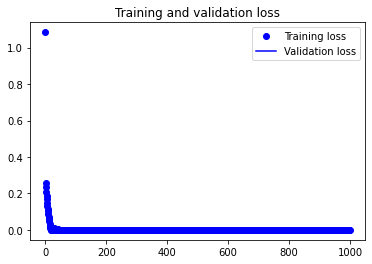

In [15]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
mycriterion = nn.MSELoss() 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-3, eps = 1e-08) 

In [21]:
# start the main training process
max_epochs = 500
print('train_data',len(train_data))
num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []

min_loss = 100000
current_patience = 0
patience = 10
best_model = MyModel(neurons = [128, 256, 512, 256, 128])

print('Start training!')

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss/num_trainbatch)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss/num_valbatch)
    #if epoch % 10 == 9:
    print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %e, val_loss: %e "% 
          (train_loss/num_trainbatch, val_loss/num_valbatch))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        best_model = mynet
        #torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}! min_loss: {} ".format(epoch+1, min_loss/num_valbatch)) 
            break  ''' 

print('FINISH.')

train_data 50470
Start training!
Epoch   1/500, train_loss: 6.220157e-02, val_loss: 3.712287e-02 
Epoch   2/500, train_loss: 3.911550e-02, val_loss: 3.761246e-02 
Epoch   3/500, train_loss: 3.916942e-02, val_loss: 3.754624e-02 
Epoch   4/500, train_loss: 3.914755e-02, val_loss: 3.732341e-02 
Epoch   5/500, train_loss: 3.923287e-02, val_loss: 3.731794e-02 
Epoch   6/500, train_loss: 3.958222e-02, val_loss: 3.743652e-02 
Epoch   7/500, train_loss: 3.917401e-02, val_loss: 3.710474e-02 
Epoch   8/500, train_loss: 3.929286e-02, val_loss: 3.717915e-02 
Epoch   9/500, train_loss: 3.908027e-02, val_loss: 3.730908e-02 
Epoch  10/500, train_loss: 3.912909e-02, val_loss: 3.716164e-02 
Epoch  11/500, train_loss: 3.916292e-02, val_loss: 3.703963e-02 
Epoch  12/500, train_loss: 3.907758e-02, val_loss: 3.728372e-02 
Epoch  13/500, train_loss: 3.903596e-02, val_loss: 3.728382e-02 
Epoch  14/500, train_loss: 3.923272e-02, val_loss: 3.721283e-02 
Epoch  15/500, train_loss: 3.911233e-02, val_loss: 3.7201

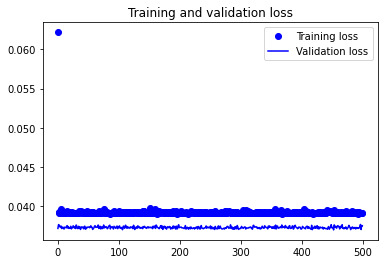

In [22]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [ ]:
# save trained model
torch.save(best_model.state_dict(),'/content/drive/My Drive/Project/model1and2/mynet2_8.pth')

In [20]:
mynet.load_state_dict(torch.load('/content/drive/My Drive/Project/model1and2/mynet2_7.pth'))

<All keys matched successfully>

In [23]:
# test inference 
test_loss = 0
for n, data in enumerate(test_loader): 
        X = torch.tensor(data[0]).cuda() 
        y = torch.tensor(data[1]).cuda()
        if n < 2:
          for i, x in enumerate(X): 
            best_model.eval()
            x = x[None, :]
            y_pred = best_model(x.to(torch.float32)) 
            if i < 50:
              print('test',i)
              print('prediction  : {},\nground truth：{}'.format(y_pred, y[i])) 
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


test 0
prediction  : tensor([[0.0203, 0.0879]], device='cuda:0', grad_fn=<AddmmBackward0>),
ground truth：tensor([0.2104, 0.0199], device='cuda:0', dtype=torch.float64)
test 1
prediction  : tensor([[0.0206, 0.1718]], device='cuda:0', grad_fn=<AddmmBackward0>),
ground truth：tensor([0.7306, 0.1291], device='cuda:0', dtype=torch.float64)
test 2
prediction  : tensor([[0.0061, 0.0853]], device='cuda:0', grad_fn=<AddmmBackward0>),
ground truth：tensor([1.0000, 0.5286], device='cuda:0', dtype=torch.float64)
test 3
prediction  : tensor([[0.0214, 0.0790]], device='cuda:0', grad_fn=<AddmmBackward0>),
ground truth：tensor([1., 1.], device='cuda:0', dtype=torch.float64)
test 4
prediction  : tensor([[-0.0159,  0.0743]], device='cuda:0', grad_fn=<AddmmBackward0>),
ground truth：tensor([ 1.0000, -0.1405], device='cuda:0', dtype=torch.float64)
test 5
prediction  : tensor([[0.0106, 0.0649]], device='cuda:0', grad_fn=<AddmmBackward0>),
ground truth：tensor([0.1810, 0.0364], device='cuda:0', dtype=torch.float